# Making Multiple Markets and GLFT Market Making Model Part 2

## Overview

In the previous tutorial, we only cover $\xi>0$ case, but $\xi=0$ case would be more simple and appropriate in practice especially in cryptocurrencies.

Revisit the equations (4.6) and (4.7) in [Optimal market making](https://arxiv.org/abs/1605.01862) and explore how they can be applied to real-world scenarios.

The optimal bid quote depth, $\delta^{b*}_{approx}$, and ask quote depth, $\delta^{a*}_{approx}$, are derived from the fair price as follows in the case of $\xi=0$:

\begin{align}
\delta^{b*}_{approx}(q) = {1 \over k} + {{2q + \Delta} \over 2}\sqrt{{{\gamma \sigma^2 e} \over {2A\Delta k}}} \label{eq4.6}\tag{4.6} \\
\delta^{a*}_{approx}(q) = {1 \over k} - {{2q - \Delta} \over 2}\sqrt{{{\gamma \sigma^2 e} \over {2A\Delta k}}} \label{eq4.7}\tag{4.7}
\end{align}

Let's introduce $c_1$ and $c_2$ and define them by extracting the volatility 𝜎 from the square root as same as before:

\begin{align}
c_1 = {1 \over k} \\
c_2 = \sqrt{{{\gamma e} \over {2A\Delta k}}}
\end{align}

Now we can rewrite equations (4.6) and (4.7) as follows:

\begin{align}
\delta^{b*}_{approx}(q) = c_1 + {\Delta \over 2} \sigma c_2 + q \sigma c_2 \\
\delta^{a*}_{approx}(q) = c_1 + {\Delta \over 2} \sigma c_2 - q \sigma c_2
\end{align}

It's more concise and only need to adjust $\gamma$ and its effect is more straightforward.

<div class="alert alert-success">
This example is for educational purposes only and demonstrates effective strategies for high-frequency market-making schemes. All backtests are based on a 0.005% rebate, the highest market maker rebate available on Binance Futures. See <a href="https://www.binance.com/en/support/announcement/binance-upgrades-usd%E2%93%A2-margined-futures-liquidity-provider-program-2023-04-04-01007356e6514df3811b0c80ab8c83bf">Binance Upgrades USDⓢ-Margined Futures Liquidity Provider Program</a> for more details.
</div>

In [1]:
from numba import njit
from numba.typed import Dict

from hftbacktest import BUY, SELL
from hftbacktest import HftBacktest, Linear, FeedLatency, SquareProbQueueModel, Stat, GTX

import numpy as np

@njit(cache=True)
def measure_trading_intensity(order_arrival_depth, out):
    max_tick = 0
    for depth in order_arrival_depth:
        if not np.isfinite(depth):
            continue
        
        # Sets the tick index to 0 for the nearest possible best price 
        # as the order arrival depth in ticks is measured from the mid-price
        tick = round(depth / .5) - 1
        
        # In a fast-moving market, buy trades can occur below the mid-price (and vice versa for sell trades) 
        # since the mid-price is measured in a previous time-step; 
        # however, to simplify the problem, we will exclude those cases.
        if tick < 0 or tick >= len(out):
            continue
        
        # All of our possible quotes within the order arrival depth, 
        # excluding those at the same price, are considered executed.
        out[:tick] += 1
        
        max_tick = max(max_tick, tick)
    return out[:max_tick]

@njit(cache=True)
def compute_coeff(gamma, delta, A, k):
    inv_k = np.divide(1, k)
    c1 = inv_k
    c2 = np.sqrt(np.divide(gamma * np.exp(1), 2 * A * delta * k))
    return c1, c2

@njit(cache=True)
def linear_regression(x, y):
    sx = np.sum(x)
    sy = np.sum(y)
    sx2 = np.sum(x ** 2)
    sxy = np.sum(x * y)
    w = len(x)
    slope = (w * sxy - sx * sy) / (w * sx2 - sx**2)
    intercept = (sy - slope * sx) / w
    return slope, intercept


@njit
def gridtrading_glft_mm(hbt, stat, order_qty):
    arrival_depth = np.full(20_000_000, np.nan, np.float64)
    mid_price_chg = np.full(20_000_000, np.nan, np.float64)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan
    
    tmp = np.zeros(500, np.float64)
    ticks = np.arange(len(tmp)) + 0.5
    
    A = np.nan
    k = np.nan
    volatility = np.nan
    gamma = 0.01
    delta = 1
    
    # adj2 is determined according to the order quantity.
    grid_num = 20
    max_position = 50 * order_qty
    
    # Checks every 100 milliseconds.
    while hbt.elapse(100_000):
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for trade in hbt.last_trades:
                side = trade[3]
                trade_price_tick = trade[4] / hbt.tick_size
                
                if side == BUY:
                    depth = np.nanmax([trade_price_tick - mid_price_tick, depth])
                else:
                    depth = np.nanmax([mid_price_tick - trade_price_tick, depth])
            arrival_depth[t] = depth
        
        hbt.clear_last_trades()
        
        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (hbt.best_bid_tick + hbt.best_ask_tick) / 2.0
        
        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick
        
        #--------------------------------------------------------
        # Calibrates A, k and calculates the market volatility.
        
        if t % 300 == 0:
            # Updates A, k, and the volatility every 30-sec.
            # Calibrates A, k
            tmp[:] = 0
            lambda_ = measure_trading_intensity(arrival_depth[max(0, t + 1 - 6_000):t + 1], tmp)

            if len(lambda_) > 2:
                lambda_ = lambda_[:70] / 600
                x = ticks[:len(lambda_)]
                y = np.log(lambda_)
                k_, logA = linear_regression(x, y)
                A = np.exp(logA)
                k = -k_
    
        # Updates the volatility.
        volatility = np.nanstd(mid_price_chg[max(0, t + 1 - 6_000):t + 1]) * np.sqrt(10)
    
        #--------------------------------------------------------
        # Computes bid price and ask price.
        
        c1, c2 = compute_coeff(gamma, delta, A, k)
        
        half_spread = c1 + delta / 2 * c2 * volatility
        skew = c2 * volatility
        
        normalized_position = hbt.position / order_qty
        
        bid_depth = half_spread + skew * normalized_position
        ask_depth = half_spread - skew * normalized_position
    
        # If the depth is invalid, set a large spread to prevent execution.
        if not np.isfinite(bid_depth):
            bid_depth = 1_000
        if not np.isfinite(ask_depth):
            ask_depth = 1_000

        bid_price = min(mid_price_tick - bid_depth, hbt.best_bid_tick) * hbt.tick_size
        ask_price = max(mid_price_tick + ask_depth, hbt.best_ask_tick) * hbt.tick_size
        
        order_interval = max(round(half_spread) * hbt.tick_size, hbt.tick_size)
        bid_price = np.floor(bid_price / order_interval) * order_interval
        ask_price = np.ceil(ask_price / order_interval) * order_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        hbt.clear_inactive_orders()
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.int64, np.float64)
        if hbt.position < max_position:
            for i in range(grid_num):
                bid_price -= i * order_interval
                bid_price_tick = round(bid_price / hbt.tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[bid_price_tick] = bid_price
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == BUY and order.cancellable and order.order_id not in new_bid_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_bid_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_buy_order(order_id, order_price, order_qty, GTX)
        
        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.int64, np.float64)
        if hbt.position > -max_position:
            for i in range(grid_num):
                ask_price += i * order_interval
                ask_price_tick = round(ask_price / hbt.tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[ask_price_tick] = ask_price
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == SELL and order.cancellable and order.order_id not in new_ask_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_ask_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_sell_order(order_id, order_price, order_qty, GTX)
        
        t += 1
        
        if t >= len(arrival_depth) or t >= len(mid_price_chg):
            raise Exception
        
        # Records the current state for stat calculation.
        stat.record(hbt)
     
@njit
def gridtrading_glft_mm_from_bbo(hbt, stat, order_qty):
    arrival_depth = np.full(20_000_000, np.nan, np.float64)
    mid_price_chg = np.full(20_000_000, np.nan, np.float64)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan
    
    tmp = np.zeros(500, np.float64)
    ticks = np.arange(len(tmp)) + 0.5
    
    A = np.nan
    k = np.nan
    volatility = np.nan
    gamma = 0.01
    delta = 1
    
    # adj2 is determined according to the order quantity.
    grid_num = 20
    max_position = 50 * order_qty
    
    # Checks every 100 milliseconds.
    while hbt.elapse(100_000):
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for trade in hbt.last_trades:
                side = trade[3]
                trade_price_tick = trade[4] / hbt.tick_size
                
                if side == BUY:
                    depth = np.nanmax([trade_price_tick - mid_price_tick, depth])
                else:
                    depth = np.nanmax([mid_price_tick - trade_price_tick, depth])
            arrival_depth[t] = depth
        
        hbt.clear_last_trades()
        
        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (hbt.best_bid_tick + hbt.best_ask_tick) / 2.0
        
        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick
        
        #--------------------------------------------------------
        # Calibrates A, k and calculates the market volatility.
        
        if t % 300 == 0:
            # Updates A, k, and the volatility every 30-sec.
            # Calibrates A, k
            tmp[:] = 0
            lambda_ = measure_trading_intensity(arrival_depth[max(0, t + 1 - 6_000):t + 1], tmp)

            if len(lambda_) > 2:
                lambda_ = lambda_[:70] / 600
                x = ticks[:len(lambda_)]
                y = np.log(lambda_)
                k_, logA = linear_regression(x, y)
                A = np.exp(logA)
                k = -k_
    
        # Updates the volatility.
        volatility = np.nanstd(mid_price_chg[max(0, t + 1 - 6_000):t + 1]) * np.sqrt(10)
    
        #--------------------------------------------------------
        # Computes bid price and ask price.
        
        c1, c2 = compute_coeff(gamma, delta, A, k)
        
        half_spread = c1 + delta / 2 * c2 * volatility
        skew = c2 * volatility
        
        normalized_position = hbt.position / order_qty
        
        bid_depth = half_spread + skew * normalized_position
        ask_depth = half_spread - skew * normalized_position
    
        # If the depth is invalid, set a large spread to prevent execution.
        if not np.isfinite(bid_depth):
            bid_depth = 1_000
        if not np.isfinite(ask_depth):
            ask_depth = 1_000

        bid_price = min(hbt.best_bid_tick - bid_depth, hbt.best_bid_tick) * hbt.tick_size
        ask_price = max(hbt.best_ask_tick + ask_depth, hbt.best_ask_tick) * hbt.tick_size
        
        order_interval = max(round(half_spread) * hbt.tick_size, hbt.tick_size)
        bid_price = np.floor(bid_price / order_interval) * order_interval
        ask_price = np.ceil(ask_price / order_interval) * order_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        hbt.clear_inactive_orders()
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.int64, np.float64)
        if hbt.position < max_position:
            for i in range(grid_num):
                bid_price -= i * order_interval
                bid_price_tick = round(bid_price / hbt.tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[bid_price_tick] = bid_price
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == BUY and order.cancellable and order.order_id not in new_bid_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_bid_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_buy_order(order_id, order_price, order_qty, GTX)
        
        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.int64, np.float64)
        if hbt.position > -max_position:
            for i in range(grid_num):
                ask_price += i * order_interval
                ask_price_tick = round(ask_price / hbt.tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[ask_price_tick] = ask_price
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == SELL and order.cancellable and order.order_id not in new_ask_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_ask_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_sell_order(order_id, order_price, order_qty, GTX)
        
        t += 1
        
        if t >= len(arrival_depth) or t >= len(mid_price_chg):
            raise Exception
        
        # Records the current state for stat calculation.
        stat.record(hbt)

The order quantity is determined to be equivalent to a notional value of $1000.

In [2]:
latency_data = np.concatenate(
    [np.load('../latency/order_latency_{}.npz'.format(date))['data'] for date in range(20230401, 20230420)]
)

In [3]:
from hftbacktest import COL_SIDE, COL_PRICE, IntpOrderLatency

def backtest1(args):
    asset_name, asset_info = args

    hbt = HftBacktest(
        ['data/{}_{}.npz'.format(asset_name, date) for date in range(20230401, 20230420)],
        tick_size=asset_info['tick_size'],
        lot_size=asset_info['lot_size'],
        maker_fee=-0.00005,
        taker_fee=0.0007,
        order_latency=IntpOrderLatency(data=latency_data),
        queue_model=SquareProbQueueModel(),
        asset_type=Linear,
        snapshot='data/{}_20230331_eod.npz'.format(asset_name),
        trade_list_size=10000
    )

    stat = Stat(hbt)

    # Obtains the mid-price of the assset to determine the order quantity.
    data = np.load('data/{}_20230331_eod.npz'.format(asset_name))['data']
    best_bid = max(data[data[:, COL_SIDE] == 1][:, COL_PRICE])
    best_ask = min(data[data[:, COL_SIDE] == -1][:, COL_PRICE])
    mid = (best_bid + best_ask) / 2.0

    # Sets the order quantity to be equivalent to a notional value of $1000.
    order_qty = max(round((1000 / mid) / asset_info['lot_size']), 1) * asset_info['lot_size']

    gridtrading_glft_mm(hbt, stat.recorder, order_qty)

    np.savez(
        '{}_stat_k1_np'.format(asset_name),
        timestamp=np.asarray(stat.timestamp),
        mid=np.asarray(stat.mid),
        balance=np.asarray(stat.balance),
        position=np.asarray(stat.position),
        fee=np.asarray(stat.fee),
    )
    
def backtest2(args):
    asset_name, asset_info = args

    hbt = HftBacktest(
        ['data/{}_{}.npz'.format(asset_name, date) for date in range(20230401, 20230420)],
        tick_size=asset_info['tick_size'],
        lot_size=asset_info['lot_size'],
        maker_fee=-0.00005,
        taker_fee=0.0007,
        order_latency=IntpOrderLatency(data=latency_data),
        queue_model=SquareProbQueueModel(),
        asset_type=Linear,
        snapshot='data/{}_20230331_eod.npz'.format(asset_name),
        trade_list_size=10000
    )

    stat = Stat(hbt)

    # Obtains the mid-price of the assset to determine the order quantity.
    data = np.load('data/{}_20230331_eod.npz'.format(asset_name))['data']
    best_bid = max(data[data[:, COL_SIDE] == 1][:, COL_PRICE])
    best_ask = min(data[data[:, COL_SIDE] == -1][:, COL_PRICE])
    mid = (best_bid + best_ask) / 2.0

    # Sets the order quantity to be equivalent to a notional value of $1000.
    order_qty = max(round((1000 / mid) / asset_info['lot_size']), 1) * asset_info['lot_size']

    gridtrading_glft_mm_from_bbo(hbt, stat.recorder, order_qty)

    np.savez(
        '{}_stat_k2_np'.format(asset_name),
        timestamp=np.asarray(stat.timestamp),
        mid=np.asarray(stat.mid),
        balance=np.asarray(stat.balance),
        position=np.asarray(stat.position),
        fee=np.asarray(stat.fee),
    )

By utilizing multiprocessing, backtesting of multiple assets can be conducted simultaneously.

In [4]:
import json

from multiprocessing import Pool

with open('assets.json', 'r') as f:
    assets = json.load(f)

## Case I

Text(0, 0.5, 'Cumulative Returns (%)')

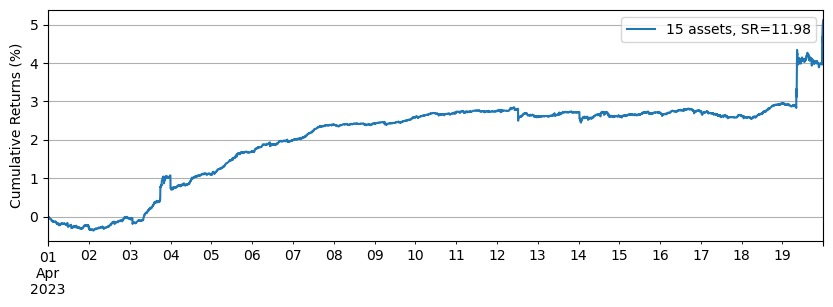

In [5]:
from matplotlib import pyplot as plt
import pandas as pd

equity_values = {}
for asset_name in list(assets.keys())[:15]:
    stat = np.load('{}_stat_k1_np.npz'.format(asset_name))
    timestamp = stat['timestamp']
    mid = stat['mid']
    balance = stat['balance']
    position = stat['position']
    fee = stat['fee']
    
    equity = mid * position + balance - fee
    equity = pd.Series(equity, index=pd.to_datetime(timestamp, unit='us', utc=True))
    equity_values[asset_name] = equity.resample('5min').last()
    
fig = plt.figure()
fig.set_size_inches(10, 3)

legend = []
net_equity = None
asset_number = len(equity_values)
for i, equity in enumerate(list(equity_values.values())):
    if net_equity is None:
        net_equity = equity.copy()
    else:
        net_equity += equity.copy()


net_equity_ = (net_equity / asset_number) / 20_000
pnl = net_equity_.diff()
sr = pnl.mean() / pnl.std() * np.sqrt(288 * 252)
legend.append('{} assets, SR={:.2f}'.format(asset_number, sr))
(net_equity_ * 100).plot()
        
plt.legend(legend)
plt.grid()
plt.ylabel('Cumulative Returns (%)')

## Case II

Text(0, 0.5, 'Cumulative Returns (%)')

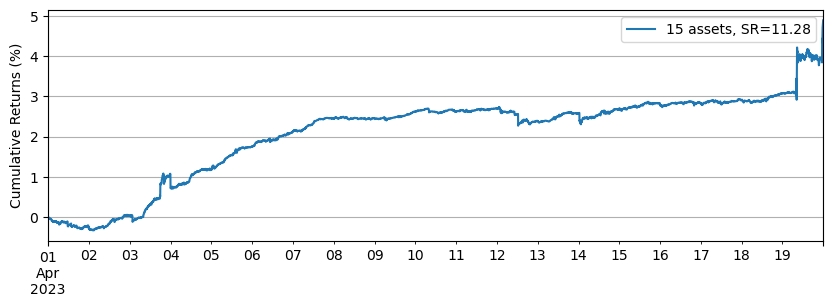

In [6]:
equity_values = {}
for asset_name in list(assets.keys())[:15]:
    stat = np.load('{}_stat_k2_np.npz'.format(asset_name))
    timestamp = stat['timestamp']
    mid = stat['mid']
    balance = stat['balance']
    position = stat['position']
    fee = stat['fee']
    
    equity = mid * position + balance - fee
    equity = pd.Series(equity, index=pd.to_datetime(timestamp, unit='us', utc=True))
    equity_values[asset_name] = equity.resample('5min').last()
    
fig = plt.figure()
fig.set_size_inches(10, 3)

legend = []
net_equity = None
asset_number = len(equity_values)
for i, equity in enumerate(list(equity_values.values())):
    if net_equity is None:
        net_equity = equity.copy()
    else:
        net_equity += equity.copy()


net_equity_ = (net_equity / asset_number) / 20_000
pnl = net_equity_.diff()
sr = pnl.mean() / pnl.std() * np.sqrt(288 * 252)
legend.append('{} assets, SR={:.2f}'.format(asset_number, sr))
(net_equity_ * 100).plot()
        
plt.legend(legend)
plt.grid()
plt.ylabel('Cumulative Returns (%)')

## Case III: With partial fill simulation from Case II

In [7]:
from hftbacktest import PartialFillExchange

def backtest3(args):
    asset_name, asset_info = args

    hbt = HftBacktest(
        ['data/{}_{}.npz'.format(asset_name, date) for date in range(20230401, 20230420)],
        tick_size=asset_info['tick_size'],
        lot_size=asset_info['lot_size'],
        maker_fee=-0.00005,
        taker_fee=0.0007,
        order_latency=IntpOrderLatency(data=latency_data),
        queue_model=SquareProbQueueModel(),
        asset_type=Linear,
        snapshot='data/{}_20230331_eod.npz'.format(asset_name),
        trade_list_size=10000,
        exchange_model=PartialFillExchange
    )

    stat = Stat(hbt)

    # Obtains the mid-price of the assset to determine the order quantity.
    data = np.load('data/{}_20230331_eod.npz'.format(asset_name))['data']
    best_bid = max(data[data[:, COL_SIDE] == 1][:, COL_PRICE])
    best_ask = min(data[data[:, COL_SIDE] == -1][:, COL_PRICE])
    mid = (best_bid + best_ask) / 2.0

    # Sets the order quantity to be equivalent to a notional value of $1000.
    order_qty = max(round((1000 / mid) / asset_info['lot_size']), 1) * asset_info['lot_size']

    gridtrading_glft_mm_from_bbo(hbt, stat.recorder, order_qty)

    np.savez(
        '{}_stat_k2'.format(asset_name),
        timestamp=np.asarray(stat.timestamp),
        mid=np.asarray(stat.mid),
        balance=np.asarray(stat.balance),
        position=np.asarray(stat.position),
        fee=np.asarray(stat.fee),
    )

Text(0, 0.5, 'Cumulative Returns (%)')

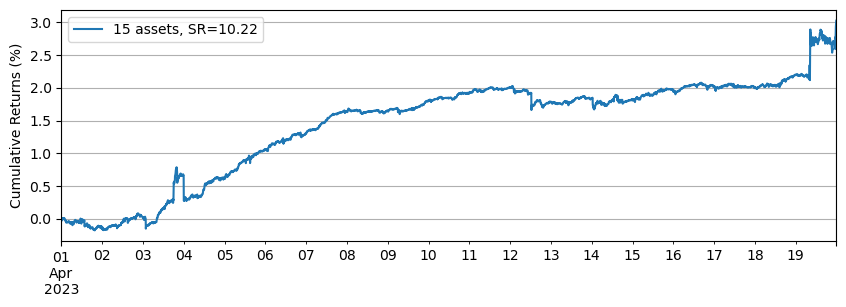

In [8]:
equity_values = {}
for asset_name in list(assets.keys())[:15]:
    stat = np.load('{}_stat_k2.npz'.format(asset_name))
    timestamp = stat['timestamp']
    mid = stat['mid']
    balance = stat['balance']
    position = stat['position']
    fee = stat['fee']
    
    equity = mid * position + balance - fee
    equity = pd.Series(equity, index=pd.to_datetime(timestamp, unit='us', utc=True))
    equity_values[asset_name] = equity.resample('5min').last()
    
fig = plt.figure()
fig.set_size_inches(10, 3)

legend = []
net_equity = None
asset_number = len(equity_values)
for i, equity in enumerate(list(equity_values.values())):
    if net_equity is None:
        net_equity = equity.copy()
    else:
        net_equity += equity.copy()


net_equity_ = (net_equity / asset_number) / 20_000
pnl = net_equity_.diff()
sr = pnl.mean() / pnl.std() * np.sqrt(288 * 252)
legend.append('{} assets, SR={:.2f}'.format(asset_number, sr))
(net_equity_ * 100).plot()
        
plt.legend(legend)
plt.grid()
plt.ylabel('Cumulative Returns (%)')